# Direct Access API Example: Rigs on a Map in a Jupyter Notebook

Retrieve Rigs in Texas, write them to a CSV, add them to a Pandas DataFrame and then a GeoDataFrame. Finally, show our results on a plot and a map.

Retrieve your credentials from https://app.drillinginfo.com/direct/#/

In [1]:
# Set our Direct Access credentials. In this case, we're using environment variables to hide our credentials.
import os
DIRECTACCESS_API_KEY = os.getenv('DIRECTACCESS_API_KEY')
DIRECTACCESS_CLIENT_ID = os.getenv('DIRECTACCESS_CLIENT_ID')
DIRECTACCESS_CLIENT_SECRET = os.getenv('DIRECTACCESS_CLIENT_SECRET')

In [2]:
# Initialize our api client object. Optionally, we can pass a logging level to avoid cluttering our notebook
import logging
from directaccess import DirectAccessV2
d2 = DirectAccessV2(
    api_key=DIRECTACCESS_API_KEY, 
    client_id=DIRECTACCESS_CLIENT_ID, 
    client_secret=DIRECTACCESS_CLIENT_SECRET,
    log_level=logging.WARNING
)

### Query the API, write to CSV and create a DataFrame

With our initialized and authenticated Direct Access object (`d2`), we're ready to query the API and write out some data.

Note that we could have just used the `from_records` method on the Pandas DataFrame and provided a list of API records, skipping the intermediate CSV. But this demonstrates a simple method of writing to CSV if that's all you need.

In [4]:
import csv
import pandas as pd

csv_file = 'TEXAS.csv'
query = d2.query('rigs', distateprovincename=csv_file[:-4])  # Rigs in TEXAS
with open(csv_file, mode='w') as f:
    writer = csv.writer(f)
    for i, row in enumerate(query, start=1):
        if i == 1:
            writer.writerow(row.keys())
        writer.writerow(row.values())

df = pd.read_csv(csv_file)
os.remove(csv_file)

### Create the GeoDataFrame and show results on a map

Now that we have our data in DataFrame, we can convert to GeoDataFrame and show our results on a map.

We'll use a small helper function to show a basemap and give some context to our results. This is provided by the Contextily module (`pip install contextily`)

This example is adapted from the GeoPandas documentation. https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html

The method of converting a Pandas Dataframe to a GeoDataFrame is adapted from this StackOverflow answer. https://gis.stackexchange.com/a/174168/36169

In [5]:
# Import the GeoDataFrame and Point classes.
from geopandas import GeoDataFrame
from shapely.geometry import Point

# Turn our Latitude and Longitude fields into a Shapely Point geometry
geometry = [Point(xy) for xy in zip(df.RigLongitudeWGS84, df.RigLatitudeWGS84)]

# Drop the Latitude and Longitude columns, though this isn't necessary
df = df.drop(['RigLongitudeWGS84', 'RigLatitudeWGS84'], axis=1)
# Set the Coordinate Reference System, which is EPSG 4326 (WGS84)
crs = {'init': 'epsg:4326'}
# Finally, create our GeoDataFrame, passing the Pandas DataFrame, the CRS and the geometry object
gdf = GeoDataFrame(df, crs=crs, geometry=geometry)

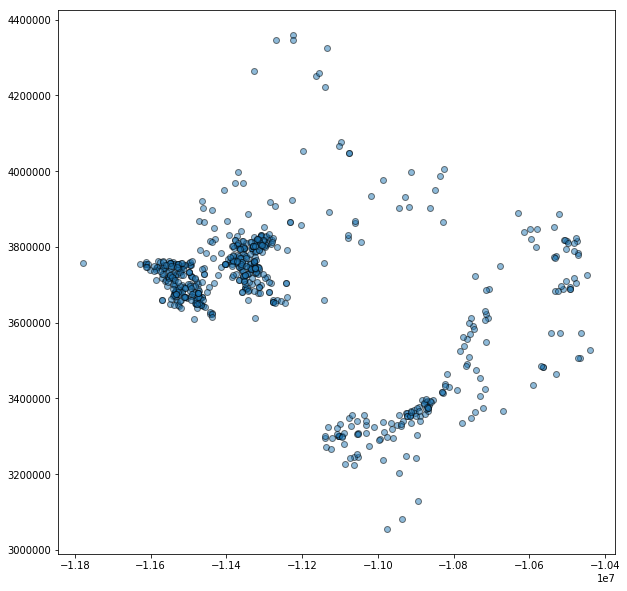

In [10]:
# Show our points on a basic plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [7]:
# Convert to Web Mercator
gdf = gdf.to_crs(epsg=3857)

In [8]:
# Create our helper function to generate a basemap in our new plot
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

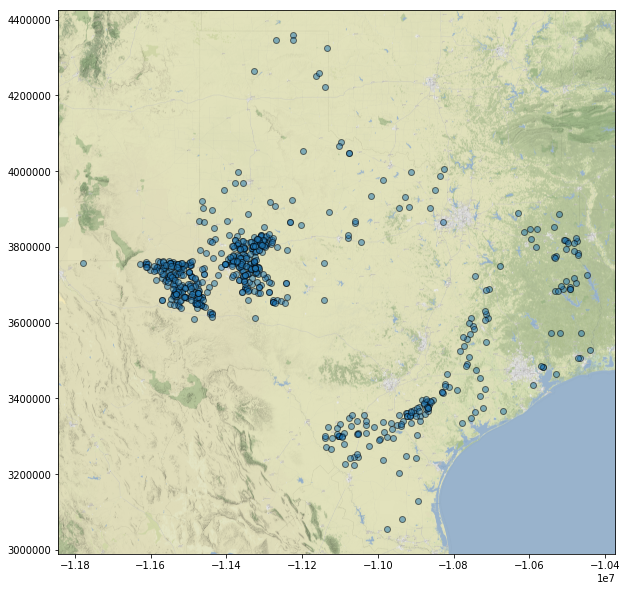

In [9]:
# Show our results on another plot with a terrain basemap (running this cell might take a moment...)
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
add_basemap(ax, zoom=10)